In [1]:
import numpy as np
import tensorflow as tf
import gym
import logz
import scipy.signal
import os
import time
import inspect
from multiprocessing import Process

register name:MaxPoolGrad, /usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:16, func:<module>


In [2]:
#============================================================================================#
# Utilities
#============================================================================================#
def build_mlp(
        input_placeholder, 
        output_size,
        scope, 
        n_layers=2, 
        size=64, 
        activation=tf.tanh,
        output_activation=None
        ):
    #========================================================================================#
    #                           ----------SECTION 3----------
    # Network building
    #
    # Your code should make a feedforward neural network (also called a multilayer perceptron)
    # with 'n_layers' hidden layers of size 'size' units. 
    # 
    # The output layer should have size 'output_size' and activation 'output_activation'.
    #
    # Hint: use tf.layers.dense
    #========================================================================================#
    print('build_mlp[%s] with n_layers:%d, size:%d, output_size:%d' % (scope, n_layers, size, output_size))
    prev = input_placeholder
    out = prev
    hidden_layers = [size] * n_layers
    with tf.variable_scope(scope):
        # YOUR_CODE_HERE
        for i, n in enumerate(hidden_layers):
            with tf.variable_scope('hidden_' + str(i)):
                out = tf.contrib.layers.fully_connected(inputs=prev, \
                                                    num_outputs=n,\
                                                    activation_fn=activation,\
                                                    normalizer_fn=None)
                prev = out

        with tf.variable_scope('/output_layer'):
            out = tf.contrib.layers.fully_connected(inputs=out, \
                                                num_outputs=output_size,\
                                                activation_fn=output_activation)

    return out
    
def pathlength(path):
    return len(path["reward"])

In [3]:
def prepare_training_data(trajectories, reward_to_go=False, gamma=1.0):
    paths = trajectories
    import time
    s = time.time()
    for p in paths:
        R = 0
        Rs = []
        rews = p['reward']
        totalr = 0
        for i in range(len(rews) - 1, -1, -1):
            r = rews[i]
            totalr += gamma * r
            R = r + gamma * R
            Rs.insert(0, R)
    
        p['totalr'] = totalr
        if reward_to_go is True:
            p['R'] = Rs
        else:
            p['R'] = [Rs[0]] * len(Rs)

    """
    for p in paths:
        rews = np.array(p['reward'])
        seq = np.power(gamma, np.arange(len(rews)))
        Rs = rews * seq
        Rs = np.cumsum(Rs)
        
        p['totalr'] = Rs[-1]
        if reward_to_go is True:
            p['R'] = Rs.tolist()
        else:
            p['R'] = [Rs[-1]] * len(Rs)
    """
    
    ob_no = np.concatenate([path["observation"] for path in paths])
    ac_na = np.concatenate([path["action"] for path in paths])    
    rewards = np.array([path["totalr"] for path in paths])
    q_n = np.concatenate([path["R"] for path in paths])
    return {'ob_no': ob_no, 'ac_na': ac_na, 'q_n': q_n, 'rewards': rewards}

In [4]:
def variable_summaries(var, name):
    """Attach a lot of summaries to a Tensor."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean/' + name, mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_sum(tf.square(var - mean)))
        tf.summary.scalar('sttdev/' + name, stddev)
        tf.summary.scalar('max/' + name, tf.reduce_max(var))
        tf.summary.scalar('min/' + name, tf.reduce_min(var))
        tf.summary.histogram(name, var)
        
def transform_grad(grads, sigma):
    grad, var_name = zip(*grads)

    for grad, var_name in grads:
        variable_summaries(grad , grad.op.name)
        if var_name == sigma:
            print('sigma var_name:', var_name)
        else:
            print('var_name:', var_name)
    return grads


In [ ]:
def train(exp_name='',
            env_name='CartPole-v0',
            n_iter=100, 
            gamma=1.0, 
            min_timesteps_per_batch=1000, 
            max_path_length=None,
            learning_rate=5e-3, 
            reward_to_go=True, 
            animate=False, 
            logdir=None, 
            normalize_advantages=True,
            nn_baseline=False, 
            seed=0,
            # network arguments
            n_layers=1,
            size=32,
            log_interval=10,
            update_times=1):
    tf.reset_default_graph()
    
    start = time.time()
    
    # Set random seeds
    tf.set_random_seed(seed)
    np.random.seed(seed)

    # Make the gym environment
    env = gym.make(env_name)
    
    # Is this env continuous, or discrete?
    discrete = isinstance(env.action_space, gym.spaces.Discrete)

    # Maximum length for episodes
    max_path_length = max_path_length or env.spec.max_episode_steps

    #========================================================================================#
    # Notes on notation:
    # 
    # Symbolic variables have the prefix sy_, to distinguish them from the numerical values
    # that are computed later in the function
    # 
    # Prefixes and suffixes:
    # ob - observation 
    # ac - action
    # _no - this tensor should have shape (batch size /n/, observation dim)
    # _na - this tensor should have shape (batch size /n/, action dim)
    # _n  - this tensor should have shape (batch size /n/)
    # 
    # Note: batch size /n/ is defined at runtime, and until then, the shape for that axis
    # is None
    #========================================================================================#

    # Observation and action sizes
    ob_shape = env.observation_space.shape
    ob_dim = ob_shape[0]
    
    ac_dim = env.action_space.n if discrete else env.action_space.shape[0]
    print('observation shape is:', env.observation_space.shape)    
    print('dim of observertion:%d, dim of action:%d' % (ob_dim, ac_dim))
    
    sy_ob_no = tf.placeholder(shape=[None, ob_dim], name="ob", dtype=tf.float32)
    if discrete:
        sy_ac_na = tf.placeholder(shape=[None], name="ac", dtype=tf.int32) 
    else:
        sy_ac_na = tf.placeholder(shape=[None, ac_dim], name="ac", dtype=tf.float32)
    sy_adv_n = tf.placeholder(shape=[None], name="advantage_score", dtype=tf.float32)
    
    #build policy net
    if discrete:
        sy_logits_na = build_mlp(sy_ob_no, 
                                ac_dim,
                                'policy_net', 
                                n_layers=n_layers, 
                                size=size, 
                                activation=tf.tanh,
                                output_activation=None)
        sy_sampled_ac = tf.squeeze(tf.multinomial(sy_logits_na, 1)) # Hint: Use the tf.multinomial op
        log_prob = tf.nn.log_softmax(sy_logits_na)
        sy_logprob_n = tf.reduce_sum(tf.one_hot(sy_ac_na, ac_dim, dtype=tf.float32) * log_prob, axis=1)
        loss = -tf.reduce_sum(sy_logprob_n * sy_adv_n, axis=0)
        update_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    else:
        sy_mean = build_mlp(sy_ob_no, 
                            ac_dim,
                            'policy_net_mean', 
                            n_layers=n_layers, 
                            size=size, 
                            activation=tf.tanh,
                            output_activation=None)
        # logstd should just be a trainable variable, not a network output.
        sy_logstd = tf.Variable(1.0 * tf.square(tf.ones(ac_dim, dtype=tf.float32)), name='policy_net_sigma')
        #sy_logstd = 0.3 * tf.ones(1, dtype=tf.float32)
        ##sy_logstd = 0.3 * tf.ones(ac_dim, dtype=tf.float32)
        dist = tf.contrib.distributions.MultivariateNormalDiag(sy_mean, sy_logstd)
        sy_sampled_ac = dist.sample()
        #sy_sampled_ac = sy_mean + sy_logstd * tf.random_normal((tf.shape(sy_mean)[0], ac_dim))
        sy_logprob_n = dist.log_prob(sy_ac_na)  # Hint: Use the log probability under a multivariate gaussian. 
        #sy_logprob_n = -tf.log(sy_logstd) - tf.reduce_sum(tf.square(sy_sampled_ac - sy_mean), axis=1)/tf.square(sy_logstd)
        #sy_logprob_n = -tf.log(sy_logstd) - tf.reduce_sum(tf.square(sy_sampled_ac - sy_mean), axis=1)
        variable_summaries(sy_logprob_n, sy_logprob_n.op.name)
        
        loss = -tf.reduce_sum(sy_logprob_n * sy_adv_n, axis=0)
        mean_grad = tf.gradients(loss, xs=sy_mean)[0]
        variable_summaries(mean_grad, mean_grad.op.name)
        
        opt = tf.train.AdamOptimizer(learning_rate)#GradientDescentOptimizer
        grads = opt.compute_gradients(loss)
        mygrads = transform_grad(grads, sy_logstd)
        #mygrads = grads
        update_op = opt.apply_gradients(mygrads)
        
    #build optimizer
    #loss = -tf.reduce_sum(sy_logprob_n * sy_adv_n)
    tf.summary.scalar('loss', loss)

    if nn_baseline:
        baseline_prediction = tf.squeeze(build_mlp(
                                sy_ob_no, 
                                1, 
                                "nn_baseline",
                                n_layers=n_layers,
                                size=size))
        # Define placeholders for targets, a loss function and an update op for fitting a 
        # neural network baseline. These will be used to fit the neural network baseline. 
        # YOUR_CODE_HERE
        sy_base_n = tf.placeholder(shape=[None], name='baseline_target', dtype=tf.float32)
        baseline_loss = tf.reduce_mean(tf.square(baseline_prediction - sy_base_n))
        baseline_update_op = tf.train.AdamOptimizer(learning_rate).minimize(baseline_loss)
        
    merged_summary_op = tf.summary.merge_all()
    with tf.Session() as sess:
        summary_writer = tf.summary.FileWriter('logs', sess.graph)
        tf.global_variables_initializer().run() #pylint: disable=E1101
        
        #========================================================================================#
        # Training Loop
        #========================================================================================#
        total_timesteps = 0
        max_epsodics = 10
        epsodics = 0
        for itr in range(n_iter):
            #print("********** Iteration %i ************"%itr)

            # Collect paths until we have enough timesteps
            timesteps_this_batch = 0
            paths = []
            while True:
                ob = env.reset()
                obs, acs, rewards = [], [], []
                animate_this_episode=(len(paths)==0 and (itr % 10 == 0) and animate)
                steps = 0
                while True:
                    if animate_this_episode:
                        #env.render()
                        #time.sleep(0.05)
                        pass
                    ob = ob.reshape(ob_shape)[None]
                    #print('shape of ob:', ob.shape)
                    #print('shape of ob[none]:', ob[None].shape)
                    obs.append(ob)
                    ac = sess.run(sy_sampled_ac, feed_dict={sy_ob_no : ob})
                    #print('got ac ', ac.shape)
                    acs.append(ac)
                    ob, rew, done, _ = env.step(ac)
                    rewards.append(rew)
                    steps += 1
                    if done or steps > max_path_length:
                        break
                path = {"observation" : np.vstack(obs), 
                        "reward" : np.array(rewards), 
                        "action" : np.vstack(acs)}
                if ac.ndim == 0:
                    path['action'] = path['action'].flatten()
                #print('shape of action:', path['action'].shape)
                paths.append(path)
                timesteps_this_batch += pathlength(path)
                if timesteps_this_batch > min_timesteps_per_batch:
                    break
                epsodics += 1
            total_timesteps += timesteps_this_batch

            # Build arrays for observation, action for the policy gradient update by concatenating 
            # across paths
            path_num = len(paths)
            train_data = prepare_training_data(paths, reward_to_go, gamma)
            ob_no = train_data['ob_no']
            ac_na = train_data['ac_na']
            q_n = train_data['q_n'].flatten()
            q_n_mean = np.mean(q_n)
            q_n_std = np.std(q_n)
                
            rewards = train_data['rewards']
            
            mean_r = np.mean(rewards)
            std_r = np.std(rewards)
    
            # YOUR_CODE_HERE
            #q_n = adv_nr

            #====================================================================================#
            #                           ----------SECTION 5----------
            # Computing Baselines
            #====================================================================================#
            if nn_baseline:
                # If nn_baseline is True, use your neural network to predict reward-to-go
                # at each timestep for each trajectory, and save the result in a variable 'b_n'
                # like 'ob_no', 'ac_na', and 'q_n'.
                #
                # Hint #bl1: rescale the output from the nn_baseline to match the statistics
                # (mean and std) of the current or previous batch of Q-values. (Goes with Hint
                # #bl2 below.)

                b_n = sess.run([baseline_prediction], feed_dict={sy_ob_no: ob_no})[0]
                if q_n_std != 0:
                    adv_n = q_n - (b_n + q_n_mean) * q_n_std
                else:
                    adv_n = q_n - (b_n + q_n_mean)
            else:
                adv_n = q_n.copy()

            #====================================================================================#
            #                           ----------SECTION 4----------
            # Advantage Normalization
            #====================================================================================#
            if normalize_advantages:
                # On the next line, implement a trick which is known empirically to reduce variance
                # in policy gradient methods: normalize adv_n to have mean zero and std=1. 
                # YOUR_CODE_HERE
                #pass
                if std_r != 0:
                    adv_n = (adv_n - mean_r)/std_r

            adv_n = adv_n / path_num
            #====================================================================================#
            #                           ----------SECTION 5----------
            # Optimizing Neural Network Baseline
            #====================================================================================#
            basel_loss = -1.0
            train_losses = []
            train_loss = 0.0
            eval_vars = [loss, update_op, merged_summary_op, sy_logprob_n]
            for i in range(update_times):
                #print('shape of ob_no:', ob_no.shape, ',shape of ac_na:', ac_na.shape)
                feed_dict = {sy_ob_no: ob_no, sy_ac_na: ac_na, sy_adv_n: adv_n.flatten()}
                if discrete:
                    train_loss, _, summary, log_prob_v = sess.run(eval_vars, feed_dict=feed_dict)
                    grad_v = -1
                else:
                    train_loss, _, summary, log_prob_v, mean_grad_v = sess.run(eval_vars + [mean_grad], feed_dict=feed_dict)
                    grad_v = np.mean(np.sqrt(np.sum(np.square(mean_grad_v), axis=1)),axis=0)

                
                summary_writer.add_summary(summary, itr*update_times + i)
                #mean_grad_v = np.mean(np.sum(np.square(mean_grad_v - mean_grad_v), axis=1))
                train_losses.append((train_loss, grad_v))
                if nn_baseline:
                    # ----------SECTION 5----------
                    # If a neural network baseline is used, set up the targets and the inputs for the 
                    # baseline. 
                    # 
                    # Fit it to the current batch in order to use for the next iteration. Use the 
                    # baseline_update_op you defined earlier.
                    #
                    # Hint #bl2: Instead of trying to target raw Q-values directly, rescale the 
                    # targets to have mean zero and std=1. (Goes with Hint #bl1 above.)

                    # YOUR_CODE_HERE
                    #pass
                    
                    if q_n_std != 0:
                        q_n = (q_n - q_n_mean)/q_n_std
                    else:
                        q_n = q_n - q_n_mean
                        
                    basel_loss, _ = sess.run([baseline_loss, baseline_update_op], 
                                             feed_dict={sy_ob_no: ob_no, sy_base_n: q_n})
                
            #print(train_loss.shape)
            if itr % log_interval == 0 or itr == n_iter - 1:
                print('iter:%d, train_loss:%.4f, baseline_loss:%.4f, eposodes:%d, reward mean:%.4f, std:%.4f' \
                      % (itr, train_loss, basel_loss, path_num, mean_r, std_r))
                print(train_losses)

In [ ]:
env_name = 'Pendulum-v0' # 'Humanoid-v1' #'InvertedPendulum-v1' #'
train(exp_name='test_PG',
        env_name=env_name,
        n_iter=100000, 
        gamma=0.9, 
        min_timesteps_per_batch=200, 
        max_path_length=100,
        learning_rate=5e-2,
        reward_to_go=True, 
        animate=False, 
        logdir=None, 
        normalize_advantages=True,
        nn_baseline=False, 
        seed=0,
        # network arguments
        n_layers=0,
        size=128,
        log_interval=200,
        update_times=2)

[2017-10-29 12:35:12,130] Making new env: Pendulum-v0


observation shape is: (3,)
dim of observertion:3, dim of action:1
build_mlp[policy_net_mean] with n_layers:0, size:128, output_size:1
var_name: <tf.Variable 'policy_net_mean//output_layer/fully_connected/weights:0' shape=(3, 1) dtype=float32_ref>
var_name: <tf.Variable 'policy_net_mean//output_layer/fully_connected/biases:0' shape=(1,) dtype=float32_ref>
sigma var_name: <tf.Variable 'policy_net_sigma:0' shape=(1,) dtype=float32_ref>
iter:0, train_loss:3422479.2500, baseline_loss:-1.0000, eposodes:2, reward mean:-551.0789, std:17.4358
[(4026.3354, 11.423845), (3422479.2, 255.49409)]
iter:200, train_loss:57622.2812, baseline_loss:-1.0000, eposodes:2, reward mean:-744.1741, std:15.7083
[(57622.281, 0.00011715668), (57622.281, 0.00011715668)]
iter:400, train_loss:17908.7344, baseline_loss:-1.0000, eposodes:2, reward mean:-764.1276, std:51.8704
[(17908.734, 3.6957637e-05), (17908.734, 3.6957637e-05)]
iter:600, train_loss:91228.3359, baseline_loss:-1.0000, eposodes:2, reward mean:-563.9219, 

iter:9800, train_loss:62390.6758, baseline_loss:-1.0000, eposodes:2, reward mean:-508.6429, std:9.8147
[(62390.68, 0.00012252755), (62390.676, 0.00012252755)]
iter:10000, train_loss:5208.8057, baseline_loss:-1.0000, eposodes:2, reward mean:-488.8443, std:112.7638
[(5208.8057, 9.4826437e-06), (5208.8057, 9.4826437e-06)]
iter:10200, train_loss:35447.1289, baseline_loss:-1.0000, eposodes:2, reward mean:-570.8721, std:19.5112
[(35447.125, 7.2420575e-05), (35447.129, 7.2420575e-05)]
iter:10400, train_loss:32360.6504, baseline_loss:-1.0000, eposodes:2, reward mean:-685.8506, std:25.8222
[(32360.652, 6.9494345e-05), (32360.65, 6.9494345e-05)]
iter:10600, train_loss:14713.8271, baseline_loss:-1.0000, eposodes:2, reward mean:-628.8134, std:51.3965
[(14713.826, 2.7101132e-05), (14713.827, 2.7101132e-05)]
iter:10800, train_loss:54610.6094, baseline_loss:-1.0000, eposodes:2, reward mean:-721.1245, std:15.9826
[(54610.609, 0.00010576599), (54610.609, 0.00010576599)]
iter:11000, train_loss:12200.666

iter:20000, train_loss:96981.5938, baseline_loss:-1.0000, eposodes:2, reward mean:-717.4481, std:8.9248
[(96981.594, 0.00018351267), (96981.594, 0.00018351267)]
iter:20200, train_loss:20485.1289, baseline_loss:-1.0000, eposodes:2, reward mean:-562.4163, std:33.1387
[(20485.129, 4.0524421e-05), (20485.129, 4.0524421e-05)]
iter:20400, train_loss:6698.0537, baseline_loss:-1.0000, eposodes:2, reward mean:-653.3474, std:118.0627
[(6698.0537, 1.3295114e-05), (6698.0537, 1.3295114e-05)]
iter:20600, train_loss:16479.9961, baseline_loss:-1.0000, eposodes:2, reward mean:-730.8669, std:53.8895
[(16479.996, 3.4150049e-05), (16479.996, 3.4150049e-05)]
iter:20800, train_loss:2769.4326, baseline_loss:-1.0000, eposodes:2, reward mean:-570.0190, std:249.3753
[(2769.4326, 5.6157905e-06), (2769.4326, 5.6157905e-06)]
iter:21000, train_loss:7344.8418, baseline_loss:-1.0000, eposodes:2, reward mean:-675.8564, std:110.9947
[(7344.8418, 1.3061433e-05), (7344.8418, 1.3061433e-05)]
iter:21200, train_loss:42498.

iter:30200, train_loss:6648.7158, baseline_loss:-1.0000, eposodes:2, reward mean:-622.7431, std:113.1341
[(6648.7153, 1.2695475e-05), (6648.7158, 1.2695475e-05)]
iter:30400, train_loss:10236.1650, baseline_loss:-1.0000, eposodes:2, reward mean:-572.3665, std:67.1306
[(10236.165, 1.8640627e-05), (10236.165, 1.8640627e-05)]
iter:30600, train_loss:8360.2686, baseline_loss:-1.0000, eposodes:2, reward mean:-625.6803, std:90.1821
[(8360.2695, 1.5688074e-05), (8360.2686, 1.5688074e-05)]
iter:30800, train_loss:24158.0977, baseline_loss:-1.0000, eposodes:2, reward mean:-574.5251, std:28.6977
[(24158.098, 4.7321351e-05), (24158.098, 4.7321351e-05)]
iter:31000, train_loss:2087380.6250, baseline_loss:-1.0000, eposodes:2, reward mean:-753.9364, std:0.4381
[(2087380.8, 0.004187678), (2087380.6, 0.004187678)]
iter:31200, train_loss:14623.8242, baseline_loss:-1.0000, eposodes:2, reward mean:-724.1727, std:59.8112
[(14623.825, 2.7967582e-05), (14623.824, 2.7967582e-05)]
iter:31400, train_loss:76776.148

iter:40400, train_loss:108862.5469, baseline_loss:-1.0000, eposodes:2, reward mean:-801.7824, std:8.9103
[(108862.55, 0.00019764013), (108862.55, 0.00019764013)]
iter:40600, train_loss:17126.6758, baseline_loss:-1.0000, eposodes:2, reward mean:-650.8943, std:45.8257
[(17126.676, 3.209179e-05), (17126.676, 3.209179e-05)]
iter:40800, train_loss:27592.5527, baseline_loss:-1.0000, eposodes:2, reward mean:-659.9984, std:29.0099
[(27592.553, 5.5914705e-05), (27592.553, 5.5914705e-05)]
iter:41000, train_loss:17698.1680, baseline_loss:-1.0000, eposodes:2, reward mean:-549.1354, std:37.6289
[(17698.17, 3.7187794e-05), (17698.168, 3.7187794e-05)]
iter:41200, train_loss:34648.5703, baseline_loss:-1.0000, eposodes:2, reward mean:-573.8333, std:19.9328
[(34648.574, 6.3883774e-05), (34648.57, 6.3883774e-05)]
iter:41400, train_loss:31296.1777, baseline_loss:-1.0000, eposodes:2, reward mean:-633.8091, std:24.4669
[(31296.18, 6.1166727e-05), (31296.178, 6.1166727e-05)]
iter:41600, train_loss:7250.0854,

iter:50600, train_loss:21293.6133, baseline_loss:-1.0000, eposodes:2, reward mean:-707.2528, std:40.2008
[(21293.615, 4.2603682e-05), (21293.613, 4.2603682e-05)]
iter:50800, train_loss:13505.4600, baseline_loss:-1.0000, eposodes:2, reward mean:-688.2927, std:61.5688
[(13505.461, 2.6474687e-05), (13505.46, 2.6474687e-05)]
iter:51000, train_loss:10583.0254, baseline_loss:-1.0000, eposodes:2, reward mean:-646.1687, std:74.2730
[(10583.025, 2.248117e-05), (10583.025, 2.248117e-05)]
iter:51200, train_loss:10633.6064, baseline_loss:-1.0000, eposodes:2, reward mean:-645.2013, std:73.6480
[(10633.605, 2.1252472e-05), (10633.606, 2.1252472e-05)]
iter:51400, train_loss:344634.2500, baseline_loss:-1.0000, eposodes:2, reward mean:-682.1630, std:2.4036
[(344634.22, 0.00068743969), (344634.25, 0.00068743969)]
iter:51600, train_loss:23130.5742, baseline_loss:-1.0000, eposodes:2, reward mean:-639.7706, std:33.5807
[(23130.574, 4.6296169e-05), (23130.574, 4.6296169e-05)]
iter:51800, train_loss:5181.422

In [20]:
env_name = 'InvertedPendulum-v1' # 'CartPole-v0' # 'Humanoid-v1' #
train(exp_name='test_PG',
        env_name=env_name,
        n_iter=100, 
        gamma=1.0, 
        min_timesteps_per_batch=1000, 
        max_path_length=150,
        learning_rate=5e-3, 
        reward_to_go=True, 
        animate=False, 
        logdir=None, 
        normalize_advantages=False,
        nn_baseline=False, 
        seed=0,
        # network arguments
        n_layers=1,
        size=32,
        log_interval=10,
        update_times=3)

[2017-10-11 20:04:17,828] Making new env: InvertedPendulum-v1


dim of observertion:4, dim of action:1
build_mlp[policy_net_mean] with n_layers:1, size:32, output_size:1
iter:0, train_loss:8348.3574, baseline_loss:-1.0000, eposodes:123, reward mean:8.1951, std:4.7123
iter:10, train_loss:8854.1709, baseline_loss:-1.0000, eposodes:106, reward mean:9.5000, std:5.6972
iter:20, train_loss:7114.2109, baseline_loss:-1.0000, eposodes:104, reward mean:9.7115, std:5.4432
iter:30, train_loss:5526.3457, baseline_loss:-1.0000, eposodes:80, reward mean:12.6375, std:6.2953
iter:40, train_loss:-1295.5925, baseline_loss:-1.0000, eposodes:55, reward mean:18.7273, std:8.7832
iter:50, train_loss:-49687.1094, baseline_loss:-1.0000, eposodes:25, reward mean:40.8800, std:5.9419
iter:60, train_loss:-38784.2812, baseline_loss:-1.0000, eposodes:27, reward mean:37.6667, std:6.3944
iter:70, train_loss:-23197.9512, baseline_loss:-1.0000, eposodes:34, reward mean:29.7353, std:10.7301
iter:80, train_loss:-22575.3828, baseline_loss:-1.0000, eposodes:36, reward mean:28.1944, std:7

In [186]:
env_name = 'InvertedPendulum-v1' #'CartPole-v0' # 'Humanoid-v1' #
train(exp_name='test_PG',
        env_name=env_name,
        n_iter=100, 
        gamma=1.0, 
        min_timesteps_per_batch=1000, 
        max_path_length=1000,
        learning_rate=5e-3, 
        reward_to_go=True, 
        animate=False, 
        logdir=None, 
        normalize_advantages=True,
        nn_baseline=False, 
        seed=0,
        # network arguments
        n_layers=1,
        size=32,
        log_interval=10,
        update_times=1)

[2017-10-08 08:59:23,268] Making new env: InvertedPendulum-v1


build_mlp[policy_net_mean] with n_layers:1, size:32, output_size:1
iter:0, train_loss:-1555.3352, baseline_loss:-1.0000, eposodes:120, reward mean:8.4083, std:4.3464
iter:10, train_loss:-1555.3352, baseline_loss:-1.0000, eposodes:104, reward mean:9.7019, std:6.1125
iter:20, train_loss:-1555.3352, baseline_loss:-1.0000, eposodes:103, reward mean:9.7476, std:6.2903
iter:30, train_loss:-1555.3352, baseline_loss:-1.0000, eposodes:123, reward mean:8.1545, std:4.1614
iter:40, train_loss:-1555.3352, baseline_loss:-1.0000, eposodes:103, reward mean:9.7961, std:7.2129
iter:50, train_loss:-1555.3352, baseline_loss:-1.0000, eposodes:109, reward mean:9.1835, std:6.3696
iter:60, train_loss:-1555.3352, baseline_loss:-1.0000, eposodes:114, reward mean:8.7807, std:4.5993
iter:70, train_loss:-1555.3352, baseline_loss:-1.0000, eposodes:106, reward mean:9.5472, std:5.5680
iter:80, train_loss:-1555.3352, baseline_loss:-1.0000, eposodes:115, reward mean:8.7043, std:5.4930
iter:90, train_loss:-1555.3352, ba

In [207]:
env_name = 'CartPole-v0' # 'Humanoid-v1' #
train(exp_name='test_PG',
        env_name=env_name,
        n_iter=100, 
        gamma=1.0, 
        min_timesteps_per_batch=1000, 
        max_path_length=1000,
        learning_rate=5e-3, 
        reward_to_go=True, 
        animate=False, 
        logdir=None, 
        normalize_advantages=False,
        nn_baseline=False, 
        seed=0,
        # network arguments
        n_layers=1,
        size=32,
        log_interval=10)

[2017-10-08 09:24:01,079] Making new env: CartPole-v0


build_mlp[policy_net] with n_layers:1, size:32, output_size:2
iter:0, train_loss:12685.7500, baseline_loss:-1.0000, eposodes:39, reward mean:26.1282, std:15.6961
iter:10, train_loss:14654.7842, baseline_loss:-1.0000, eposodes:28, reward mean:37.0357, std:15.0178
iter:20, train_loss:23271.3008, baseline_loss:-1.0000, eposodes:17, reward mean:61.2941, std:26.9679
iter:30, train_loss:26114.1836, baseline_loss:-1.0000, eposodes:14, reward mean:72.9286, std:30.1744
iter:40, train_loss:47972.6250, baseline_loss:-1.0000, eposodes:7, reward mean:152.1429, std:23.4608
iter:50, train_loss:52771.4648, baseline_loss:-1.0000, eposodes:6, reward mean:170.1667, std:44.8792
iter:60, train_loss:58397.8594, baseline_loss:-1.0000, eposodes:6, reward mean:174.3333, std:57.3924
iter:70, train_loss:57894.8125, baseline_loss:-1.0000, eposodes:7, reward mean:157.4286, std:52.0381
iter:80, train_loss:51108.0078, baseline_loss:-1.0000, eposodes:7, reward mean:149.1429, std:49.8008
iter:90, train_loss:54212.8906

In [208]:
env_name = 'CartPole-v0' # 'Humanoid-v1' #
train(exp_name='test_PG',
        env_name=env_name,
        n_iter=100, 
        gamma=1.0, 
        min_timesteps_per_batch=1000, 
        max_path_length=1000,
        learning_rate=5e-3, 
        reward_to_go=True, 
        animate=False, 
        logdir=None, 
        normalize_advantages=True,
        nn_baseline=False, 
        seed=0,
        # network arguments
        n_layers=1,
        size=32,
        log_interval=10)

[2017-10-08 09:26:14,441] Making new env: CartPole-v0


build_mlp[policy_net] with n_layers:1, size:32, output_size:2
iter:0, train_loss:89.3361, baseline_loss:-1.0000, eposodes:62, reward mean:16.2581, std:6.9001
iter:10, train_loss:-7.2787, baseline_loss:-1.0000, eposodes:36, reward mean:29.0278, std:16.8168
iter:20, train_loss:0.0486, baseline_loss:-1.0000, eposodes:23, reward mean:43.8696, std:17.7306
iter:30, train_loss:-4.2498, baseline_loss:-1.0000, eposodes:18, reward mean:59.0556, std:26.2604
iter:40, train_loss:9.2492, baseline_loss:-1.0000, eposodes:10, reward mean:103.2000, std:34.5190
iter:50, train_loss:-3.0482, baseline_loss:-1.0000, eposodes:10, reward mean:110.2000, std:36.1934
iter:60, train_loss:-1.7484, baseline_loss:-1.0000, eposodes:9, reward mean:125.8889, std:36.9006
iter:70, train_loss:2.9968, baseline_loss:-1.0000, eposodes:6, reward mean:181.8333, std:25.9642
iter:80, train_loss:10.7621, baseline_loss:-1.0000, eposodes:6, reward mean:200.0000, std:0.0000
iter:90, train_loss:-7.6472, baseline_loss:-1.0000, eposodes

In [113]:
env_name = 'Humanoid-v1' #'CartPole-v0' 
train(exp_name='test_PG',
        env_name=env_name,
        n_iter=5000, 
        gamma=0.99, 
        min_timesteps_per_batch=256, 
        max_path_length=1000,
        learning_rate=5e-3, 
        reward_to_go=True, 
        animate=False, 
        logdir=None, 
        normalize_advantages=False,
        nn_baseline=False, 
        seed=0,
        # network arguments
        n_layers=3,
        size=500,
        log_interval=500)

[2017-10-05 18:04:24,700] Making new env: Humanoid-v1


build_mlp with n_layers:3, size:500, output_size:17
iter:0, train_loss:-0.0273, eposodes:13, reward mean:96.0326, std:25.4822
iter:500, train_loss:-0.0030, eposodes:13, reward mean:103.7971, std:43.4864
iter:1000, train_loss:-0.0053, eposodes:14, reward mean:88.1666, std:16.0619
iter:1500, train_loss:0.0066, eposodes:14, reward mean:90.1150, std:16.2712
iter:2000, train_loss:0.0062, eposodes:12, reward mean:104.3743, std:29.8465
iter:2500, train_loss:0.0072, eposodes:10, reward mean:125.3235, std:57.0810
iter:3000, train_loss:-0.0105, eposodes:12, reward mean:103.4091, std:34.4896
iter:3500, train_loss:-0.0018, eposodes:10, reward mean:122.5525, std:42.2272
iter:4000, train_loss:-0.0066, eposodes:10, reward mean:123.9491, std:27.0924
iter:4500, train_loss:0.0025, eposodes:10, reward mean:120.0301, std:32.3679
iter:4999, train_loss:-0.0054, eposodes:8, reward mean:158.0869, std:59.1357


In [131]:
env_name = 'CartPole-v0' # 'Humanoid-v1' 
train(exp_name='test_PG',
        env_name=env_name,
        n_iter=100, 
        gamma=0.99, 
        min_timesteps_per_batch=256, 
        max_path_length=1000,
        learning_rate=5e-3, 
        reward_to_go=True, 
        animate=False, 
        logdir=None, 
        normalize_advantages=False,
        nn_baseline=False, 
        seed=0,
        # network arguments
        n_layers=3,
        size=32,
        log_interval=10)

[2017-10-06 08:27:35,921] Making new env: CartPole-v0


build_mlp with n_layers:3, size:32, output_size:2
iter:0, train_loss:-0.0015, eposodes:12, reward mean:23.6667, std:8.6827
iter:10, train_loss:-0.0727, eposodes:2, reward mean:141.5000, std:0.5000
iter:20, train_loss:0.0359, eposodes:2, reward mean:143.5000, std:56.5000
iter:30, train_loss:-0.0255, eposodes:2, reward mean:198.0000, std:2.0000
iter:40, train_loss:-0.0032, eposodes:2, reward mean:200.0000, std:0.0000
iter:50, train_loss:-0.0361, eposodes:2, reward mean:200.0000, std:0.0000
iter:60, train_loss:-0.0574, eposodes:2, reward mean:200.0000, std:0.0000
iter:70, train_loss:-0.0024, eposodes:2, reward mean:150.5000, std:48.5000
iter:80, train_loss:-0.0099, eposodes:2, reward mean:146.0000, std:20.0000
iter:90, train_loss:0.0111, eposodes:3, reward mean:109.3333, std:21.4838
iter:99, train_loss:-0.0162, eposodes:4, reward mean:72.7500, std:25.9651


In [3]:
def plot_results(arglogdirs, arglegends=None, argvalue=None): 
    from plot import get_datasets, plot_data
    if argvalue is None:
        argvalue = 'AverageReturn'

    use_legend = False
    if arglegends is not None:
        assert len(arglegends) == len(arglogdirs), \
            "Must give a legend title for each set of experiments."
        use_legend = True

    data = []
    if use_legend:
        for logdir, legend_title in zip(arglogdirs, arglegends):
            data += get_datasets(logdir, legend_title)
    else:
        for logdir in arglogdirs:
            data += get_datasets(logdir)

    if isinstance(argvalue, list):
        values = argvalue
    else:
        values = [argvalue]
    for value in values:
        plot_data(data, value=value)

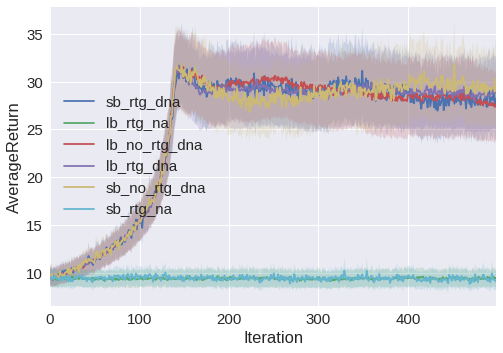

In [21]:
logdirs = ['data']
plot_results(logdirs)

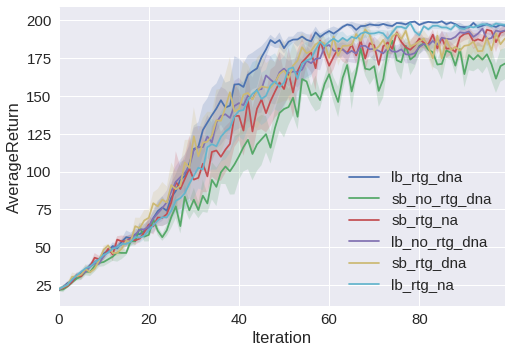

In [176]:
logdirs = ['data.CartPole']
plot_results(logdirs)

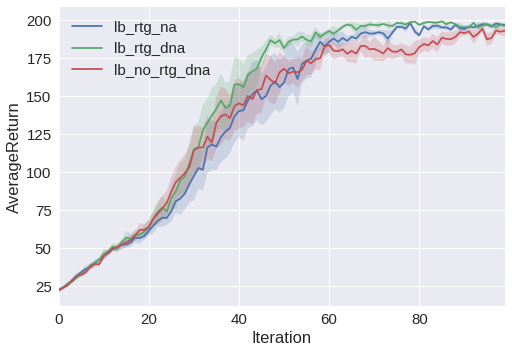

In [161]:
logdirs = ['data/lb_rtg_na_CartPole-v0_07-10-2017_11-33-41', 
           'data/lb_rtg_dna_CartPole-v0_07-10-2017_11-06-49',
           'data/lb_no_rtg_dna_CartPole-v0_07-10-2017_10-39-50']
plot_results(logdirs)

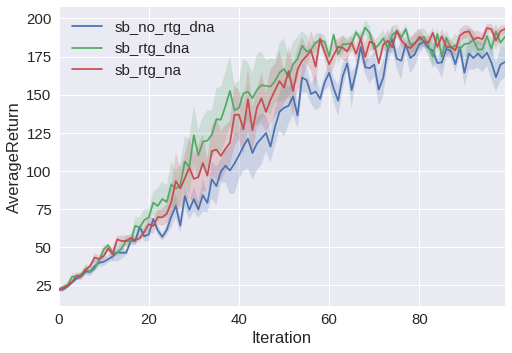

In [170]:
logdirs = ['data.CartPole/sb_no_rtg_dna_CartPole-v0_07-10-2017_12-05-42', 
           'data.CartPole/sb_rtg_dna_CartPole-v0_07-10-2017_10-27-23',
           'data.CartPole/sb_rtg_na_CartPole-v0_07-10-2017_10-33-39']
plot_results(logdirs)